In [1]:
using Random 
using Plots
using LaTeXStrings

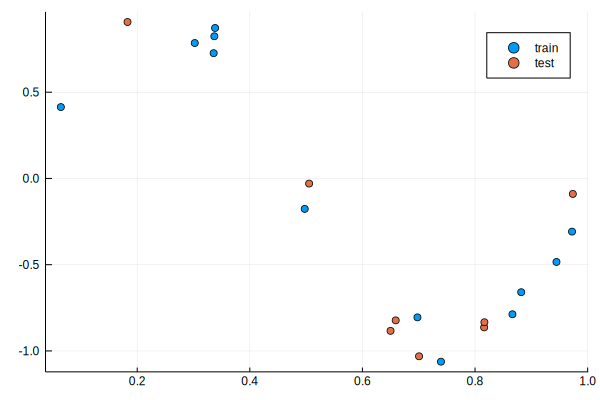

In [2]:
Random.seed!(143);
n=20
x=rand(n);
y=sin.(2*pi *x )+randn(n)*0.1;
train_test_fraction=0.6
train_range=1:floor(Int,train_test_fraction*n)
test_range=floor(Int,train_test_fraction*n)+1:n
x_train=x[train_range]
y_train=y[train_range]
x_test=x[test_range]
y_test=y[test_range];
scatter(x_train,y_train, label="train")
scatter!(x_test,y_test, label="test")

# Build a model to find any order $M$ polynomial. 

In [3]:
poly_fit(x,y, m) = hcat(ones(length(x)), [x.^i for i=1:m]...)\y

poly_predit(x,w)=sum(w[i]*x^(i-1) for i in eachindex(w))

E(f,w,x,t)=sum(([f(i,w) for i in x].-t).^2)/2

E (generic function with 1 method)

In [4]:
# The training error 
W=[poly_fit(x_train,y_train,m) for m=0:9];
E_train=[E(poly_predit,w,x_train,y_train) for w in W]
E_test=[E(poly_predit,w,x_test,y_test) for w in W]
Erms_train=sqrt.(2*E_train/length(train_range))
Erms_test=sqrt.(2*E_test/length(test_range));

# Observe test vs. train and plot it. 

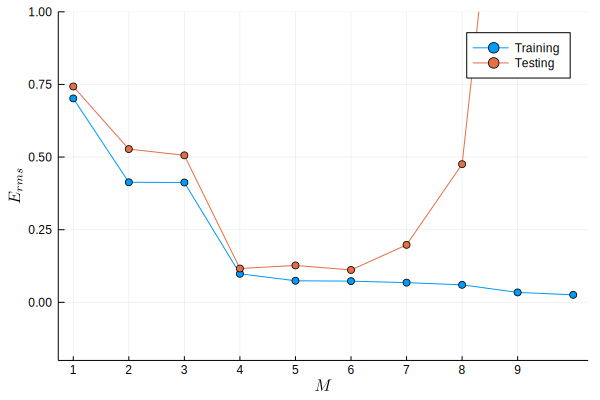

In [5]:
plot([Erms_train,Erms_test], labels=["Training"  "Testing"], xlabel=L"M", ylabel=L"E_{rms}", 
    markershape=:circle,
    ylim=(-0.2,1),
    xticks=(1:9, string.(1:9)))

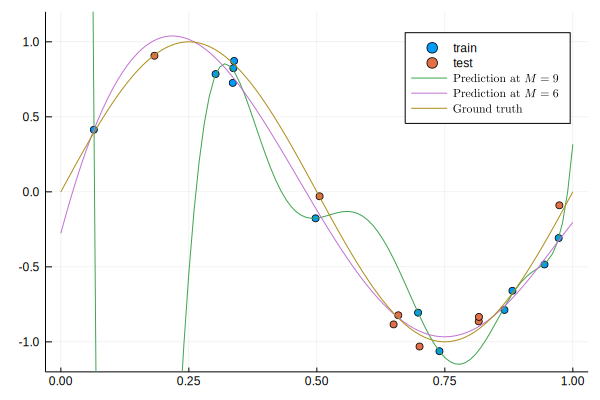

In [6]:
scatter(x_train,y_train, label="train")
scatter!(x_test,y_test, label="test")
plot!(0:0.01:1, x->poly_predit(x,W[9]), label=L"\mbox{Prediction at } M=9")
plot!(0:0.01:1, x->poly_predit(x,W[6]), label=L"\mbox{Prediction at } M=6")
plot!(0:0.01:1, x->sin(2π*x), label=L"\mbox{Ground truth}", ylim=(-1.2,1.2))

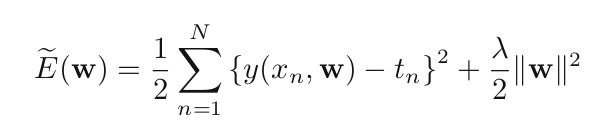

To differnitaite the above with respect to $\mathbf{w}$. 

$\frac{d E}{d\mathbf{w}}=\sum_{n=1}^{N}\left(y(x_n,\mathbf{w})-t_n \right) \frac{d y(x_n,\mathbf{w})}{d\mathbf{w}} +\lambda\mathbf{w}$

The orginal function 
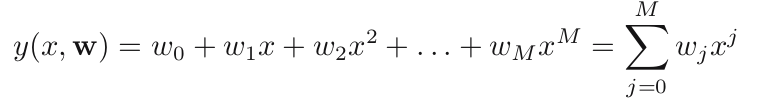

$\frac{d y(x_n,\mathbf{w})}{d\mathbf{w}}=[1,x,x^2, \ldots, x^M]^T$

To minimize the error function... 

$\mathbf{w}=\mathbf{w}-\delta\frac{d E}{d\mathbf{w}}$

where $\delta$ is a learning rate

In [7]:
"""
This function does gradient descent. It takes any function of the form 
f(x,w) returning a scaler  and the derivative of the form 
df(x,w) returing a vector 
"""
function gradient_descent(f,df,w₀,x,y; steps=1000, δ=0.01, reports=10)
    report_int=(reports>0) ? steps÷reports : 0
    w=w₀
    for i=1:steps 
        dE_dw=sum((f(x[i],w)-y[i])*df(x[i],w) for i in eachindex(x))
        w=w-δ*dE_dw
        if reports>0&&i%report_int==0
           println("The error is $(E(f,w,x,y))")
        end
    end
    w
end

gradient_descent

In [8]:
df(x,w)=[x^i for i=0:length(w)-1]

df (generic function with 1 method)

In [9]:
w₀=randn(10)*5;

In [10]:
w=gradient_descent(poly_predit,df,w₀,x_train,y_train, steps=100000, δ=0.01)

The error is 0.2315729690373331
The error is 0.18781428744664358
The error is 0.15587000179250893
The error is 0.13119356324772807
The error is 0.11211729943218446
The error is 0.0973671936419064
The error is 0.08595915939651282
The error is 0.07713297586738262
The error is 0.07030136093356625
The error is 0.06501063020095872


10-element Array{Float64,1}:
   0.17346467970296667
   5.888184731157127
 -12.248764214196303
  -3.791939656899319
   7.4071963530812575
  -3.256086431814361
   1.0420501715578663
  13.616156636421147
   0.8833992201607108
  -9.907336016907298

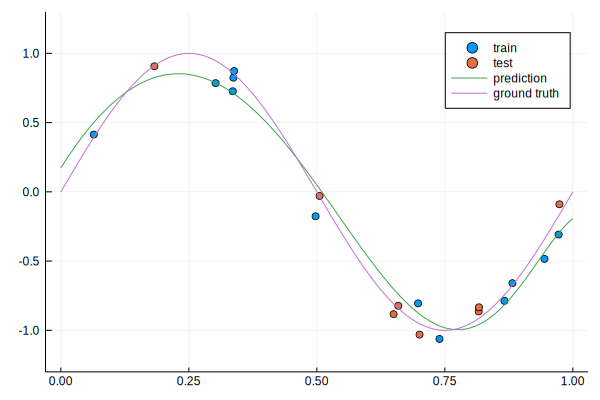

In [11]:
scatter(x_train,y_train, label="train")
scatter!(x_test,y_test, label="test")
plot!(0:0.01:1, x->poly_predit(x,w), label="prediction")
plot!(0:0.01:1, x->sin(2π*x), label="ground truth", ylim=(-1.3,1.3))

This is working okay. But now I could try to check I could make it a bit better 

In [12]:
using BenchmarkTools

In [13]:
@benchmark w=gradient_descent(poly_predit,df,w₀,x_train,y_train, steps=100000, δ=0.01, reports=0)

BenchmarkTools.Trial: 
  memory estimate:  717.16 MiB
  allocs estimate:  12400004
  --------------
  minimum time:     1.157 s (3.60% GC)
  median time:      1.173 s (3.67% GC)
  mean time:        1.172 s (3.76% GC)
  maximum time:     1.196 s (3.90% GC)
  --------------
  samples:          5
  evals/sample:     1

That is a lot memory allocation! This likely to be happening inside the sum. We can do a better job. 

In [14]:
"""
This function does gradient descent. It takes any function of the form 
f(x,w) returning a scaler  and the derivative of the form 
df(x,w) returing a vector 
"""
function gradient_descent(f,df,w₀,x,y; steps=1000, δ=0.01, reports=10)
    report_int=(reports>0) ? steps÷reports : 0
    w=copy(w₀) #To prevent side effects as we will be modifying it in place
    dE_dw=similar(w)
    for i=1:steps 
        fill!(dE_dw,zero(eltype(w)))
        for j=1:length(x)
            dE_dw.+=(f(x[j],w)-y[j])*df(x[j],w)
        end
        @. w=w-δ*dE_dw
        if reports>0&&i%report_int==0
           println("The error is $(E(f,w,x,y))")
        end
    end
    w
end

gradient_descent

In [15]:
@benchmark w=gradient_descent(poly_predit,df,w₀,x_train,y_train, steps=100000, δ=0.01, reports=0)

BenchmarkTools.Trial: 
  memory estimate:  421.14 MiB
  allocs estimate:  4800005
  --------------
  minimum time:     974.956 ms (2.19% GC)
  median time:      984.400 ms (2.44% GC)
  mean time:        984.976 ms (2.41% GC)
  maximum time:     995.778 ms (2.17% GC)
  --------------
  samples:          6
  evals/sample:     1

We shave more on the memory allocatio and speed... but maybe we could do better. 

We still we shave off more in the memory alloaction. So towards that end we used a *generator* instead of an array outptut for `df`. We also extracted the `(f(x[j],w)-y[j])` out of the loop for faster computation and less allocation. 

In [16]:
df(x,w)=(x^i for i=0:length(w)-1)
function gradient_descent(f,df,w₀,x,y; steps=1000, δ=0.01, reports=10)
    report_int=(reports>0) ? steps÷reports : 0
    w=copy(w₀) #To prevent side effects as we will be modifying it in place
    M=length(w)
    dE_dw=similar(w)
    for i=1:steps 
        fill!(dE_dw,zero(eltype(w)))
        for j=1:length(x)
            cf =(f(x[j],w)-y[j])
            for (k, df_v)=enumerate(df(x[j],w))
                dE_dw[k]+=cf*df_v
            end 
        end
        @. w=w-δ*dE_dw
        if reports>0&&i%report_int==0
           println("The error is $(E(f,w,x,y))")
        end
        end
    w
end
@benchmark w=gradient_descent(poly_predit,df,w₀,x_train,y_train, steps=100000, δ=0.01, reports=0)

BenchmarkTools.Trial: 
  memory estimate:  54.93 MiB
  allocs estimate:  2400005
  --------------
  minimum time:     967.019 ms (0.57% GC)
  median time:      971.996 ms (0.60% GC)
  mean time:        971.953 ms (0.68% GC)
  maximum time:     976.117 ms (0.52% GC)
  --------------
  samples:          6
  evals/sample:     1

We really cut down the memory alloaction here but speed did not improve much. 

Now we could see what happens if we use an array instead the generator.

In [17]:
df(x,w)=[x^i for i=0:length(w)-1]
@benchmark w=gradient_descent(poly_predit,df,w₀,x_train,y_train, steps=100000, δ=0.01, reports=0)

BenchmarkTools.Trial: 
  memory estimate:  238.04 MiB
  allocs estimate:  3600005
  --------------
  minimum time:     931.872 ms (1.72% GC)
  median time:      945.765 ms (1.72% GC)
  mean time:        944.978 ms (1.81% GC)
  maximum time:     956.591 ms (2.04% GC)
  --------------
  samples:          6
  evals/sample:     1

This is the best time so far (slightly), but we used up a bit of memory. 

Finally lets try things out with Threads. In my case I have 12 threads that Julia can use. 

In [18]:
df(x,w)=(x^i for i=0:length(w)-1)
function gradient_descent(f,df,w₀,x,y; steps=1000, δ=0.01, reports=10)
    report_int=(reports>0) ? steps÷reports : 0
    w=copy(w₀) #To prevent side effects as we will be modifying it in place
    M=length(w)
    dE_dw=similar(w)
    Threads.@threads for i=1:steps 
        fill!(dE_dw,zero(eltype(w)))
        for j=1:length(x)
            cf =(f(x[j],w)-y[j])
            for (k, df_v)=enumerate(df(x[j],w))
                dE_dw[k]+=cf*df_v
            end 
        end
        @. w=w-δ*dE_dw
        if reports>0&&i%report_int==0
           println("The error is $(E(f,w,x,y))")
        end
        end
    w
end
@benchmark w=gradient_descent(poly_predit,df,w₀,x_train,y_train, steps=100000, δ=0.01, reports=0)

BenchmarkTools.Trial: 
  memory estimate:  54.94 MiB
  allocs estimate:  2400071
  --------------
  minimum time:     206.674 ms (0.00% GC)
  median time:      260.020 ms (0.00% GC)
  mean time:        264.125 ms (6.99% GC)
  maximum time:     445.083 ms (39.09% GC)
  --------------
  samples:          19
  evals/sample:     1

This is the best speed so far. We also didn't use much memory here. 

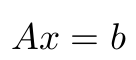

$$A^TAx=b$$

# A bit of Montecarlo simulation 

Represnting a problem 
Socks=1 and Shirt=2
Brown Shoes=5 and Black=6

In the below example I have two boxes. 

* Box 1 contians 4 Socks and 3 shirts 
* Box 2 contains 2 Brown shoes and 3 Black shoes  

What is the proablity of picking a Sock and a Black shoe?

In [19]:
n=1000000
c=count(x->x[1]==1&&x[2]==6 ,((rand([1,1,1,1,2,2,2]),rand([5,5,6,6,6])) for i=1:n))
p=c/n

0.343836

Probability of picking a Sock 

$p_1=\frac{4}{7}$

Probability of picking a Black shoe

$p_2=\frac{3}{5}$

Therefore we expect to get the answer at 

$p_1p_2=\frac{12}{35} \approx 0.34286 $

this maches the above quite well. 


We could also be a little fancy with repeat...as in below 

In [20]:
n=1000000
c=count(x->x[1]=="so"&&x[2]=="bl" ,((rand([repeat(["so"],4)...,repeat(["sh"],3)...]),rand([repeat(["br"],2)...,repeat(["bl"],3)...])) for i=1:n))
p=c/n

0.342964